In [3]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import tensorflow_datasets as tfds

In [4]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteGRPO7X/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteGRPO7X/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteGRPO7X/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [1]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [5]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [6]:
import math

batch_size_for_training = 64
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  4096
Validation steps:  256
Testing steps:  256


In [7]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

Models

Models 1, 2, 3

In [31]:
# Building the Convolutonal Nueral Network Model 1.1 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Rely activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = hinge
model_1_1_version_1 = Model(inputs=input, outputs = output)
model_1_1_version_1.compile(optimizer='adam', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_1_1_version_1.summary()
#plot_model(model_1_1_version_1)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 20, 20, 64)        184

In [30]:
# Building the Convolutonal Nueral Network Model 1.2 Version

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Rely activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function =   MSE
model_1_2_version_1 = Model(inputs=input, outputs = output)
model_1_2_version_1.compile(optimizer='adam', 
              loss='MSE',
              metrics=['acc'])

model_1_2_version_1.summary()
#plot_model(model_1_2_version_1)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 20, 20, 64)        184

In [32]:
# Building the Convolutonal Nueral Network Model 2.1 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = hinge
model_2_1_version_1 = Model(inputs=input, outputs = output)
model_2_1_version_1.compile(optimizer='adam', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_2_1_version_1.summary()
#plot_model(model_2_1_version_1)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 20, 20, 64)        184

In [33]:
# Building the Convolutonal Nueral Network Model 2.2 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = MSE
model_2_2_version_1 = Model(inputs=input, outputs = output)
model_2_2_version_1.compile(optimizer='adam', 
              loss='MSE',
              metrics=['acc'])

model_2_2_version_1.summary()
#plot_model(model_2_2_version_1)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 20, 20, 64)        184

In [34]:
# Building the Convolutonal Nueral Network Model 3.1 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = hinge
model_3_1_version_1 = Model(inputs=input, outputs = output)
model_3_1_version_1.compile(optimizer='adam', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_3_1_version_1.summary()
#plot_model(model_3_1_version_1)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 20, 20, 64)        184

In [35]:
# Building the Convolutonal Network Model 3.2 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = MSE
model_3_2_version_1 = Model(inputs=input, outputs = output)
model_3_2_version_1.compile(optimizer='adam', 
              loss='MSE',
              metrics=['acc'])

model_3_2_version_1.summary()
#plot_model(model_3_2_version_1)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 20, 20, 64)        184

Epoch 1/10
4096/4096 [==============================] - 95s 23ms/step - loss: 0.9880 - acc: 0.5122 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 2/10
4096/4096 [==============================] - 93s 23ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 3/10
4096/4096 [==============================] - 90s 22ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 4/10
4096/4096 [==============================] - 92s 22ms/step - loss: 0.9998 - acc: 0.5002 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 83s 20ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 82s 20ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 87s 21ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 8/10
4096/4096 [==========================

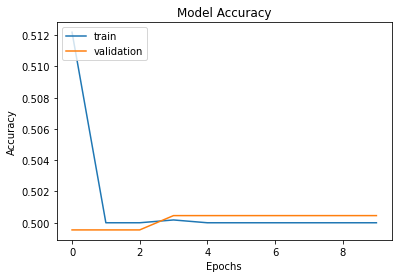

In [36]:
# Training the model 1.1 Version 1

history_1_1_version_1= model_1_1_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_1_version_1)

Epoch 1/10
4096/4096 [==============================] - 90s 22ms/step - loss: 0.1304 - acc: 0.8176 - val_loss: 0.1174 - val_acc: 0.8393
Epoch 2/10
4096/4096 [==============================] - 111s 27ms/step - loss: 0.0916 - acc: 0.8768 - val_loss: 0.1432 - val_acc: 0.8025
Epoch 3/10
4096/4096 [==============================] - 90s 22ms/step - loss: 0.0773 - acc: 0.8972 - val_loss: 0.1258 - val_acc: 0.8309
Epoch 4/10
4096/4096 [==============================] - 86s 21ms/step - loss: 0.0682 - acc: 0.9105 - val_loss: 0.1210 - val_acc: 0.8373
Epoch 5/10
4096/4096 [==============================] - 88s 21ms/step - loss: 0.0618 - acc: 0.9194 - val_loss: 0.1481 - val_acc: 0.8108
Epoch 6/10
4096/4096 [==============================] - 90s 22ms/step - loss: 0.0559 - acc: 0.9280 - val_loss: 0.1358 - val_acc: 0.8228
Epoch 7/10
4096/4096 [==============================] - 91s 22ms/step - loss: 0.0509 - acc: 0.9351 - val_loss: 0.1212 - val_acc: 0.8474
Epoch 8/10
4096/4096 [=========================

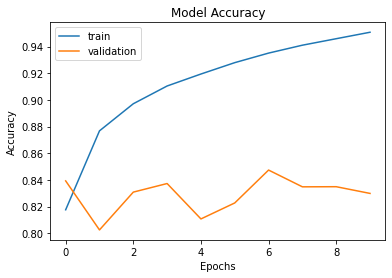

In [37]:
# Training the model 1.2 Version 1

history_1_2_version_1= model_1_2_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_2_version_1)

Epoch 1/10
4096/4096 [==============================] - 91s 22ms/step - loss: 1.0002 - acc: 0.4998 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 108s 26ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 92s 22ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 84s 21ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 91s 22ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 90s 22ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 91s 22ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 8/10
4096/4096 [=========================

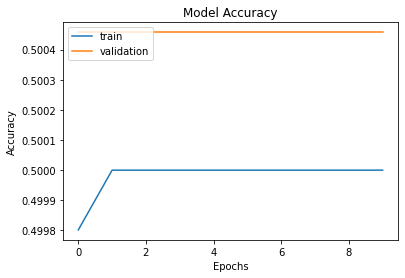

In [38]:
# Training the model 2.1 Version 1

history_2_1_version_1= model_2_1_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_1_version_1)

Epoch 1/10
4096/4096 [==============================] - 93s 22ms/step - loss: 0.2516 - acc: 0.4999 - val_loss: 0.2502 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 86s 21ms/step - loss: 0.2500 - acc: 0.5009 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 89s 22ms/step - loss: 0.2500 - acc: 0.5014 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 105s 26ms/step - loss: 0.2500 - acc: 0.5004 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 87s 21ms/step - loss: 0.2500 - acc: 0.5005 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 85s 21ms/step - loss: 0.2500 - acc: 0.5003 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 90s 22ms/step - loss: 0.2500 - acc: 0.5003 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 8/10
4096/4096 [=========================

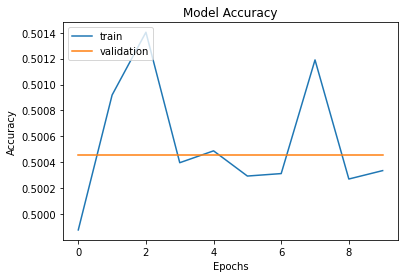

In [39]:
# Training the model 2.2 Version 1

history_2_2_version_1= model_2_2_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_2_version_1)

Epoch 1/10
4096/4096 [==============================] - 91s 22ms/step - loss: 0.9992 - acc: 0.5008 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 110s 27ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 85s 21ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 86s 21ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 87s 21ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 89s 22ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 83s 20ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 8/10
4096/4096 [=========================

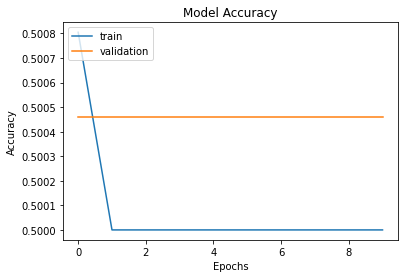

In [40]:
# Training the model 3.1 Version 1

history_3_1_version_1= model_3_1_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_1_version_1)

Epoch 1/10
4096/4096 [==============================] - 91s 22ms/step - loss: 0.2067 - acc: 0.6721 - val_loss: 0.1804 - val_acc: 0.7293
Epoch 2/10
4096/4096 [==============================] - 85s 21ms/step - loss: 0.1639 - acc: 0.7639 - val_loss: 0.1657 - val_acc: 0.7621
Epoch 3/10
4096/4096 [==============================] - 84s 21ms/step - loss: 0.1413 - acc: 0.8010 - val_loss: 0.1488 - val_acc: 0.7805
Epoch 4/10
4096/4096 [==============================] - 85s 21ms/step - loss: 0.1303 - acc: 0.8166 - val_loss: 0.1454 - val_acc: 0.7828
Epoch 5/10
4096/4096 [==============================] - 82s 20ms/step - loss: 0.1206 - acc: 0.8312 - val_loss: 0.1406 - val_acc: 0.7952
Epoch 6/10
4096/4096 [==============================] - 88s 21ms/step - loss: 0.1144 - acc: 0.8409 - val_loss: 0.1504 - val_acc: 0.7860
Epoch 7/10
4096/4096 [==============================] - 83s 20ms/step - loss: 0.1098 - acc: 0.8490 - val_loss: 0.1473 - val_acc: 0.7912
Epoch 8/10
4096/4096 [==========================

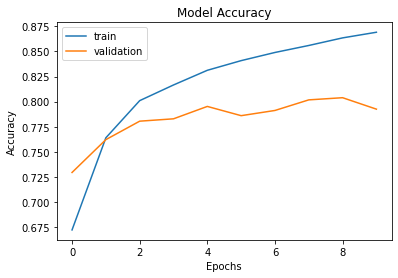

In [41]:
# Training the model 3.2 Version 1

history_3_2_version_1= model_3_2_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_2_version_1)

In [42]:
import joblib

# Models 1.1., 1.2, 2.1, 2.2, 3.1, 3.2
joblib.dump(model_1_1_version_1, 'model_1_1_version_1')
joblib.dump(model_1_2_version_1, 'model_1_2_version_1')

joblib.dump(model_2_1_version_1, 'model_2_1_version_1')
joblib.dump(model_2_2_version_1, 'model_2_2_version_1')

joblib.dump(model_3_1_version_1, 'model_3_1_version_1')
joblib.dump(model_3_2_version_1, 'model_3_2_version_1')

INFO:tensorflow:Assets written to: ram://87f10e23-e859-41d0-89ae-7792704c9c89/assets


INFO:tensorflow:Assets written to: ram://87f10e23-e859-41d0-89ae-7792704c9c89/assets


INFO:tensorflow:Assets written to: ram://23bc6ef9-b1ab-49d3-a732-38606dce29d7/assets


INFO:tensorflow:Assets written to: ram://23bc6ef9-b1ab-49d3-a732-38606dce29d7/assets


INFO:tensorflow:Assets written to: ram://8e4915d5-5e95-4534-a1f7-df6b748f746f/assets


INFO:tensorflow:Assets written to: ram://8e4915d5-5e95-4534-a1f7-df6b748f746f/assets


INFO:tensorflow:Assets written to: ram://e14b3e58-eaf8-443c-8622-d714bcb9effe/assets


INFO:tensorflow:Assets written to: ram://e14b3e58-eaf8-443c-8622-d714bcb9effe/assets


INFO:tensorflow:Assets written to: ram://b2870baf-e302-4145-969e-8e60b87f87c1/assets


INFO:tensorflow:Assets written to: ram://b2870baf-e302-4145-969e-8e60b87f87c1/assets


INFO:tensorflow:Assets written to: ram://028d36f3-7c16-4cbf-8aac-b9657bc4c3af/assets


INFO:tensorflow:Assets written to: ram://028d36f3-7c16-4cbf-8aac-b9657bc4c3af/assets


['model_3_2_version_1']

Loading the saved models

In [43]:
# Models 1.1., 1.2, 2.1, 2.2, 3.1, 3.2

model_1_1_version_1_object = joblib.load('model_1_1_version_1')
model_1_2_version_1_object = joblib.load('model_1_2_version_1')

model_2_1_version_1_object = joblib.load('model_2_1_version_1')
model_2_2_version_1_object = joblib.load('model_2_2_version_1')

model_3_1_version_1_object = joblib.load('model_3_1_version_1')
model_3_2_version_1_object = joblib.load('model_3_2_version_1')

In [44]:
# Models 1.1., 1.2, 2.1, 2.2, 3.1, 3.2


print("Test dataset accuracy for model 1.1 version 1 is: {0:.4f}".format(model_1_1_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 1.2 version 1 is: {0:.4f}".format(model_1_2_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

print("Test dataset accuracy for model 2.1 version 1 is: {0:.4f}".format(model_2_1_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 1.2 version 1 is: {0:.4f}".format(model_2_2_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

print("Test dataset accuracy for model 3.1 version 1 is: {0:.4f}".format(model_3_1_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 3.2 version 1 is: {0:.4f}".format(model_3_2_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))


256/256 [==============================] - 8s 30ms/step - loss: 0.9998 - acc: 0.5002
Test dataset accuracy for model 1.1 version 1 is: 0.5002
256/256 [==============================] - 9s 34ms/step - loss: 0.1503 - acc: 0.8135
Test dataset accuracy for model 1.2 version 1 is: 0.8135
256/256 [==============================] - 9s 34ms/step - loss: 0.9998 - acc: 0.5002
Test dataset accuracy for model 2.1 version 1 is: 0.5002
256/256 [==============================] - 9s 34ms/step - loss: 0.2500 - acc: 0.5002
Test dataset accuracy for model 1.2 version 1 is: 0.5002
256/256 [==============================] - 9s 35ms/step - loss: 0.9998 - acc: 0.5002
Test dataset accuracy for model 3.1 version 1 is: 0.5002
256/256 [==============================] - 9s 35ms/step - loss: 0.1477 - acc: 0.7955
Test dataset accuracy for model 3.2 version 1 is: 0.7955
